In [3]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_regression, make_classification
from matplotlib import pyplot as plt
import re

from packages.Util import CV, Bootstrap
from packages.Trees import ClassifierTree, RegressionTree

# Classification

Toy dataset for classification task

In [13]:
#X, y= make_classification(n_samples=500, n_features=10, n_classes=2)
dataset = load_wine()
X, y = dataset.data, dataset.target #another dataset.
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=24)

------------------------------------------------------------------------------------------------------------------------

In [15]:
Classifier = ClassifierTree(5,5, 0.)
Classifier.fit(X_train, y_train)
preds = Classifier.predict(X_test)
preds

array([0, 1, 0, 0, 0, 1, 1, 0, 2, 1, 0, 2, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 2, 2, 1, 1, 0, 1, 2, 0, 1, 2, 2, 0, 1, 0, 1, 0, 2, 2,
       1], dtype=int64)

To calibrate the algorithm, here I use the module imported from the well-known sklearn: We can find that they give almost identical predictions. 

In [22]:
skl = DecisionTreeClassifier(splitter="best", random_state=42, max_depth=4)
skl.fit(X_train,y_train)
skl_preds = skl.predict(X_test)
skl_preds

array([0, 1, 0, 0, 1, 1, 1, 0, 2, 1, 0, 2, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 2, 2, 1, 1, 0, 1, 2, 0, 1, 2, 2, 0, 1, 0, 1, 1, 2, 2,
       1])

In [24]:
accuracy1 = (preds==y_test).sum() / y_test.size
accuracy2 = (skl_preds==y_test).sum() / y_test.size
print(f"My accuracy: {accuracy1}")
print(f"sklearn accuracy: {accuracy2}")

My accuracy: 0.8666666666666667
sklearn accuracy: 0.8888888888888888


The prediction accuracy also coincides.

## Cross-validation for choosing $\alpha$

In [3]:
opts = {"error_type":"Misclassification",
       "alpha": 0.}
Misclassification = []
obj = CV(X, y, 10, ClassifierTree)
for alpha in np.linspace(0,0.2,51):
    opts["alpha"] = alpha
    cv_error = obj.Tree_CV(opts)
    Misclassification.append(cv_error)

Above we choose a proper range of __$\alpha$__ and choose the best one by comparing cross-validation misclassification error

In [4]:
lowest_error = Misclassification[np.argmin(np.array(Misclassification))] # this is the lowest misclassification rate by CV
alpha = np.linspace(0,0.2,51)[np.argmin(np.array(Misclassification))] # this is the best alpha chosen by CV
(alpha, lowest_error)

(0.012, 0.10065359477124185)

In [35]:
Cls = ClassifierTree(5,5,alpha) # plug in the optimal alpha and train the tree with the training/test split dataset.
Cls.fit(X_train, y_train)
nn = Cls.node_number # the number of tree nodes with penalty alpha.
Cls0 = ClassifierTree(5,5,0.)
Cls0.fit(X_train,y_train)
nn0 = Cls0.node_number # the number of tree nodes without any penalty, given the same full data as above.
print(f"Number of tree nodes without pruning: {nn0}")
print(f"Number of tree nodes with pruning: {nn}")

Number of tree nodes without pruning: 8
Number of tree nodes with pruning: 7


We can see after pruning the tree, the number of nodes decrease to 7 from 8. And now take a look at the prediction accuracy of the two models:

In [36]:
preds = Cls.predict(X_test)
preds0 = Cls0.predict(X_test)
accuracy = (preds==y_test).sum() / y_test.size
accuracy0 = (preds0==y_test).sum() / y_test.size
print(f"Accuracy without pruning:{accuracy0}")
print(f"Accuracy with pruning:{accuracy}")

Accuracy without pruning:0.9777777777777777
Accuracy with pruning:1.0


## Bootstrap and Bagging
Bagging provides another way to predict on testing data and can reduce testing error by removing the extra variance caused by bagging estimator $\hat f^{*}(x)$ when samples come from the true population. When using non-parametric bootstrap to draw samples from the original data, it will usually decrease the testing error as well. More details in ESL(Element of Statistical Learning) book.

In [9]:
BS = Bootstrap(X_train, y_train, ClassifierTree)
BS.bagging_fit()
preds1 = BS.tree_predict(X_test, "Consensus")
preds2 = BS.tree_predict(X_test, "Probability")

When making predictions for classification task by bagging, we have two choices:

1. Majority vote: for each observation, vote for the most occuring class out of B predictions by B models.
2. Averaged probability: for each observation, calculate the averaged probabilities of each class out of B models, and choose the class with the highest averaged probability. Here the probability of each class is evaluated at the node where this testing observation belongs to.

In [10]:
accuracy1 = np.mean(preds1==y_test)
accuracy2 = np.mean(preds2==y_test)
print(f"Making prediction by majority vote: {accuracy1}")
print(f"Making prediction by averaged class-wise probability: {accuracy2}")

Making prediction by majority vote: 0.8888888888888888
Making prediction by averaged class-wise probability: 0.8888888888888888


Bagging not only offers a way to assess the prediction, it can also be used to estimate the the out-of-bag error, which is similar to that of cross-validation. Since we know for each observation in the original data, there are around $\frac{B}{3}$ bootstrap models not containing it, so these models can then be used to do the testing-prediction for this observation. Similar to cross-validation, with this setting we can also do tuning parameter selection! Furthermore, if number of bootstrap sets $B$ is large enough, the OOB error is actually the LOOCV error! (for observation i, when B large enough, everytime the data used for training includes all the data except the i-th observation)

In [11]:
BS.OOB_error(B=100, error_type="Misclassification")

0.06015037593984962

# Regression

Toy dataset for regression task

In [2]:
x_full, y_full, coef = make_regression(n_samples=200,n_features=10, coef=True)
X_train, X_test, y_train, y_test = train_test_split(x_full, y_full, random_state=42)

------------------------------------------------------------------------------------------------------------------------

In [11]:
B = RegressionTree(5,5, 0.)
B.fit(X_train, y_train)
preds = B.predict(X_test[0])

In [12]:
preds

array([-37.84539275])

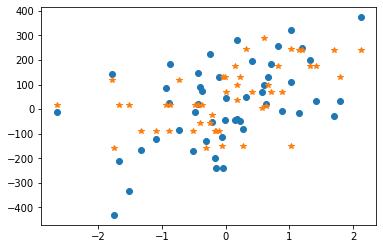

In [26]:
plt.plot(X_test[:,np.argmax(coef)], y_test, "o")
plt.plot(X_test[:,np.argmax(coef)], preds, "*")

## Cross-validation for choosing penalty tuning parameter $\alpha$

The process of implementing cross-validation for penalized regression tree is similar to what we have done for classification tree. One noticeable thing is that when comparing whether to split or not at each node, I used $log(rss)$ instead just $rss$, this will make life easier to choose tuning parameter. Otherwise for some data with very large response values, a small $\alpha$ can be neglected.

In [54]:
alphas = np.linspace(0,0.3,51)

In [55]:
opts = {"error_type":"RSS",
       "alpha": 0.}
Rss = []
obj = CV(x_full, y_full, 10, RegressionTree)
for alpha in alphas:
    opts["alpha"] = alpha
    cv_error = obj.Tree_CV(opts)
    Rss.append(cv_error)

In [62]:
lowest_rss = Rss[np.argmin(np.array(Rss))]
alpha = alphas[np.argmin(np.array(Rss))]
(alpha, lowest_rss) #the optimal alpha and the coresponding cross validation error. 

(0.192, 318971.1746505328)

In [60]:
RT = RegressionTree(5,5,alpha) # plug in the optimal alpha and train the tree with the training/test split dataset.
RT.fit(X_train, y_train)
nn = RT.node_number # the number of tree nodes with penalty alpha.

RT0 = RegressionTree(5,5,0.)
RT0.fit(X_train,y_train)
nn0 = RT0.node_number # the number of tree nodes without any penalty, given the same data as above.
print(f"Number of tree nodes without pruning: {nn0}")
print(f"Number of tree nodes with pruning: {nn}")

Number of tree nodes without pruning: 27
Number of tree nodes with pruning: 15


In [76]:
preds = RT.predict(X_test)
preds0 = RT0.predict(X_test)
RSS = np.sum(np.square(preds-y_test))
RSS0 = np.sum(np.square(preds0-y_test))
print(f"Prediction RSS without pruning:{RSS0}")
print(f"Prediction RSS with pruning:{RSS}")

Prediction RSS without pruning:1270358.3138742454
Prediction RSS with pruning:772178.7529989025


As we can see above, adding some penalty term really reduces prediction error! And we use only 15 nodes instead of 27.

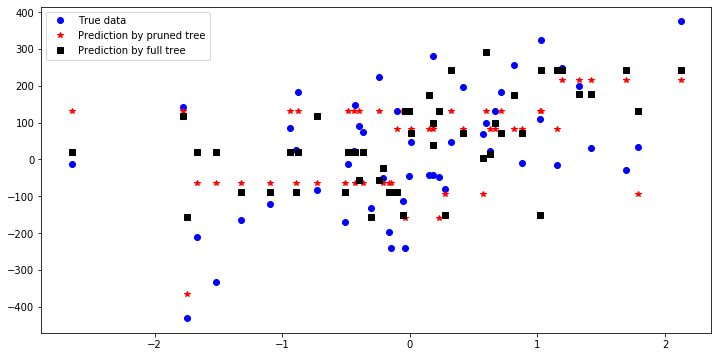

In [75]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(X_test[:,np.argmax(coef)], y_test, "bo", label="True data")
ax.plot(X_test[:,np.argmax(coef)], preds, "r*", label="Prediction by pruned tree")
ax.plot(X_test[:,np.argmax(coef)], preds0, "ks", label="Prediction by full tree")
ax.legend()

Visulization tells that the full tree performs worse on those distant points, however pruned tree more or less catches those points! 

## Bootstrap and Bagging
Similar to classification, just with different metrics.

In [3]:
BS = Bootstrap(X_train, y_train, RegressionTree)
BS.bagging_fit(10)
preds = BS.tree_predict(X_test, "Average")

In [5]:
MSE = np.mean(np.square(preds-y_test)) 
MSE

20914.05600534899

In [4]:
MSE1 = BS.OOB_error(B=10, error_type="MSE")
MSE1

23194.41612245535

------------------------------------------------------------------------------------------------------------------------------